# Optimization of the cantilever beam

## Import libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch import optim

from NN_library.SPD_CNN_modular import *
from utilities.dataset import *
from utilities.save_load import *
from utilities.FEM_2d_elasticity import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using device: cuda


## Load data and the network

In [2]:
# Initialize the dataset
data = dataset_opt()

# Load the network: 'dev' - CPU or CUDA device, 'train_mode' - to obtain K_grid or C_grid, here we only need the K_grid
args = {'dev' : dev, 'name' : 'NN_library/NN_anisotropic_6x6_[1, 3]', 'train_mode' : 'stiffness'}
network = SPD_CNN(res=5, kernels=[1, 3], train_mode=args['train_mode'], input=1)
network = load_network(network, args['name'], args)
network = network.to(dev)
for p in network.parameters():
    p.requires_grad_ = False
network.eval()

SPD_CNN(
  (conv_blocks): ModuleList(
    (0): Conv_block(
      (c11): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
      (c12): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv_block(
      (c11): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (c12): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (FNN_blocks): ModuleList(
    (0): SPD_Block(
      (convt): ConvTranspose2d(32, 1, kernel_size=(1, 36), stride=(1, 36), bias=False)
    )
    (1): SPD_Block(
      (convt): ConvTranspose2d(64, 1, kernel_size=(1, 528), stride=(1, 528), bias=False)
    )
  )
)

## Optimize the 5x4 cantilever beam

In [3]:
batch = 128

# load the data sample
layout, support, force, zero_map, DBC, f = data.__getitem__(6)
layout = layout[0].repeat(batch, 1, 1, 1).to(dev)
f = f.to(dev).repeat(batch, 1, 1)
zero_map = zero_map.repeat(batch, 1, 1)
DBC = DBC.repeat(batch, 1, 1).to(dev)

In [7]:
# Conversion between one-hot and numerical encoding
def convert(input, layout):
    x = torch.arange(2, 5).to(device=dev)
    output_one_hot = F.gumbel_softmax(input, tau=1, hard=True, eps=1e-10, dim=1)
    output_x_num = (output_one_hot * x.view(1,3,1,1)).sum(dim=1, keepdim=True)
    output_clean = output_x_num * layout[:, [0]].detach()
    return output_clean

In [4]:
# initialize the log-probabilities
x_0 = torch.zeros(batch, 3, layout.shape[-2], layout.shape[-1]).to(dev)
x_0.requires_grad_()

# initialize the list to collect the cost function values
us = []
outputs = []
loss = []

In [5]:
optimizer = optim.Adam([x_0], lr = 0.2, maximize=False)

In [8]:
for i in range(50):
    # Convert the log-probabilities to a layout with Gumbel-max
    y = convert(x_0, layout)
    # Keep the structure symmetrical 
    y[:, :, 3] = y[:, :, 0]
    y[:, :, 2] = y[:, :, 1]
    # Estimate the global stiffness matrix
    K = network(y, zero_map, DBC, f)
    # Solve the Ku = f
    _, u = find_deform(K+DBC, f)
    # Find the average cost function
    l = u.mean()
    # Optimizer step
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    # Save individual values of the cost function
    loss.append(l.detach().cpu())
    us.append(u.detach().cpu())
    outputs.append(y.detach().cpu())

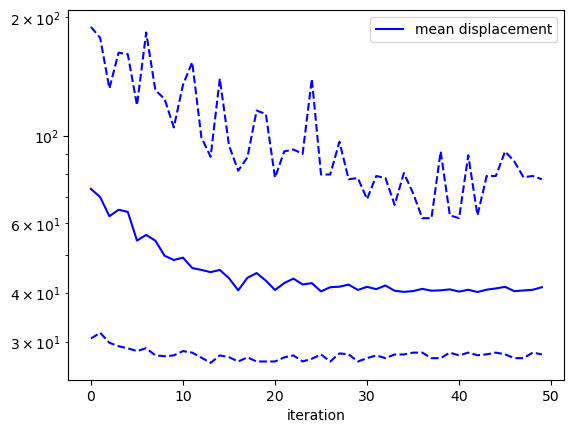

In [10]:
disps = np.array(us)
plt.plot(np.mean(disps, axis=1), 'b')
plt.plot(np.max(disps, axis=1), 'b--')
plt.plot(np.min(disps, axis=1), 'b--')
plt.xlabel('iteration')
plt.legend(['mean displacement'])
plt.yscale('log')

## Compare the results to the global minimum

In [11]:
# Global minimum
y_min = torch.tensor([[[2., 4., 2., 4., 4.],
                       [4., 4., 4., 4., 4.],
                       [4., 4., 4., 4., 4.],
                       [2., 4., 2., 4., 4.], 
                       [0., 0., 0., 0., 0.]]])

K = network(y_min.to(dev), zero_map[[0]], DBC[[0]], f[[0]])
_, u_min = find_deform(K+DBC[[0]], f[[0]])

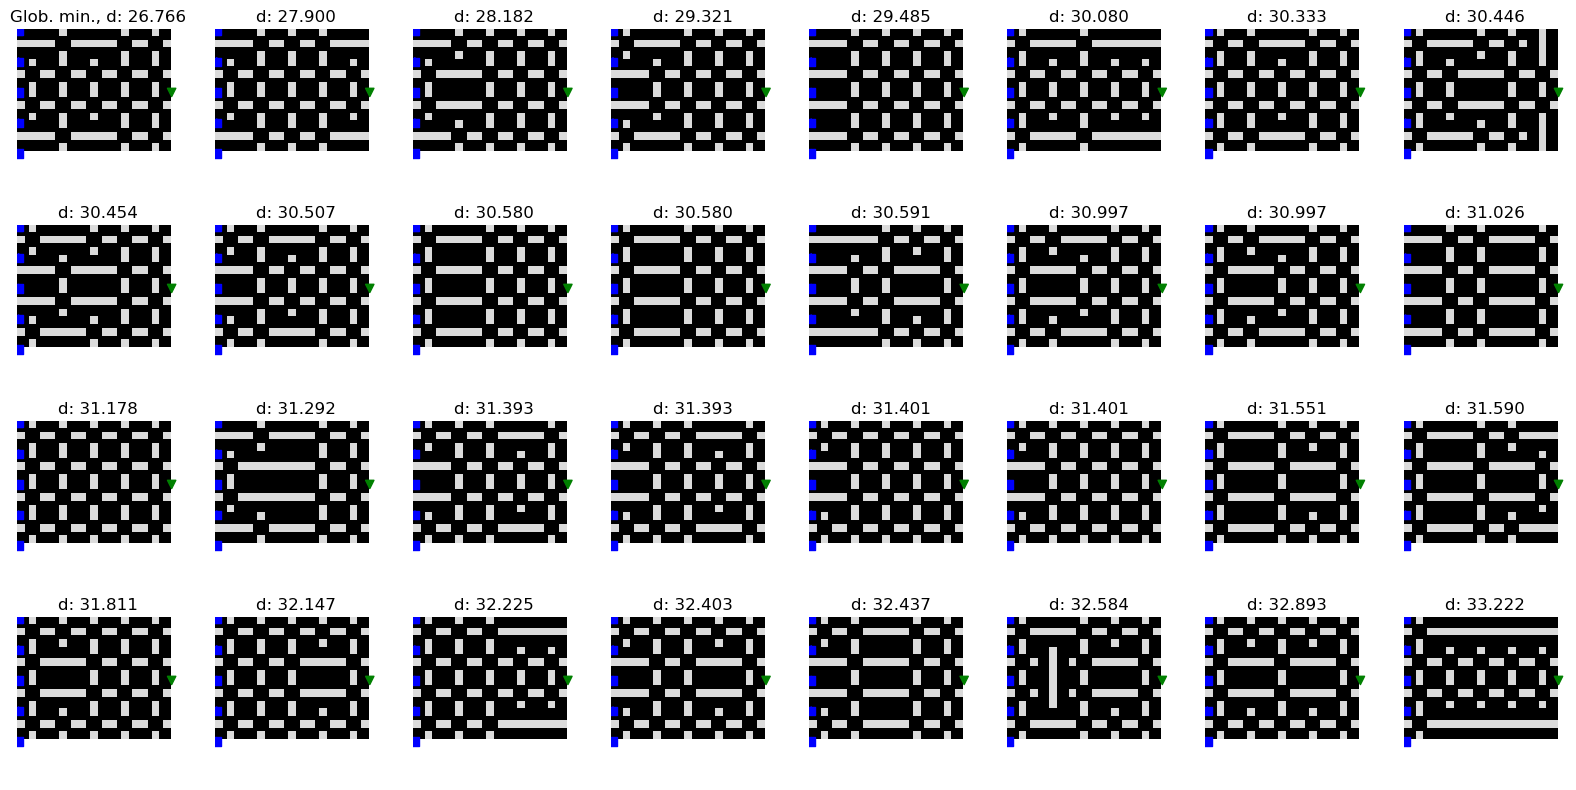

In [12]:
batch = 32
x_g, y_g = np.meshgrid(np.linspace(0, layout.shape[-2]*8, layout.shape[-2]+1), np.linspace(0, layout.shape[-1]*8, layout.shape[-1]+1))
fig, axs = plt.subplots(batch//8, 8, figsize=(2*8, 2*batch//8))
best_idx = torch.argsort(us[-1])
for j in range(batch-1):
    i = best_idx[j].item()
    img = create_image_3(outputs[-1][i])
    axs.flat[j+1].imshow(img, cmap='Greys_r')
    axs.flat[j+1].scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
    axs.flat[j+1].scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
    axs.flat[j+1].scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
    axs.flat[j+1].scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
    axs.flat[j+1].set_title(f'd: {us[-1][i]:.3f}')
    axs.flat[j+1].axis('off')
axs.flat[0].imshow(create_image_3(torch.cat([y_min, y_min])), cmap='Greys_r')
axs.flat[0].scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
axs.flat[0].scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
axs.flat[0].scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
axs.flat[0].scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
axs.flat[0].set_title(f'Glob. min., d: {u_min.item():.3f}')
axs.flat[0].axis('off')
plt.tight_layout()

## Verify the results with FEA

In [11]:
# Define the domain
coarse_grid = (5, 5)
res = 8
coarse_x, coarse_y = np.meshgrid(np.arange(coarse_grid[0]+1), np.arange(coarse_grid[1]+1))
coarse_coordinates = np.vstack([coarse_x.flatten(), coarse_y.flatten()]).T
x, y = np.meshgrid(np.linspace(0, coarse_grid[0], coarse_grid[0]*res+1), np.linspace(0, coarse_grid[1], coarse_grid[1]*res+1))
x = x.flatten()
y = y.flatten()
glob_numbering = np.reshape(np.arange(len(x)), (coarse_grid[0]*res+1, coarse_grid[1]*res+1))
coarse_idx = glob_numbering[0::res,0::res].flatten()


# Create DNS module stiffness matrices
K_module = {}
for i in range(1, 5):   
    K_module[(i, i)] = create_module_domain_from_png(1, 1e-2, 0.3, f'modules_3/{i}.png')
K_module[(0, 0)] = np.zeros_like(K_module[(1, 1)])

# Calculate the global minimum with FEA
y_bf = torch.cat([y_min, y_min], dim=0)
support_coarse = list(range(0, 2*(coarse_grid[0]-1)*(coarse_grid[1]+1)+1, 2*(coarse_grid[1]+1))) + list(range(1, 2*(coarse_grid[0]-1)*(coarse_grid[1]+1)+2, 2*(coarse_grid[1]+1))) 
support_hd = 2 * coarse_idx[np.array(support_coarse) // 2] + (np.array(support_coarse) % 2)
force_idx = np.vstack([2*coarse_idx, 2*coarse_idx+1]).T.flatten()
coarse_with_BC_idx = np.setdiff1d(force_idx, support_hd, assume_unique=False)
row_mask = np.isin(force_idx, coarse_with_BC_idx)
mask = np.outer(row_mask, row_mask)
F_glob = np.zeros((2*len(x), 1))
F_glob[force_idx] = f[0].detach().cpu()
f_idx = np.argwhere(f[0].detach().cpu().numpy())[0,0]
K_glob = assemble_global_stiffness(K_module, y_bf.detach().cpu().numpy().reshape(2, -1).T, coarse_grid, len(x), res)

K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
U_glob = np.zeros((2*len(x), 1))
U_glob[dof] = U_ff
u_min_FEA = U_glob[force_idx][f_idx]

In [14]:
# verify the final batch with FEA
u_real = []
for n in range(128):
    K_glob = assemble_global_stiffness(K_module, torch.cat([outputs[-1][n], outputs[-1][n]], dim=0).detach().cpu().numpy().reshape(2, -1).T, 
                                       coarse_grid, len(x), res)
    K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
    U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
    U_glob = np.zeros((2*len(x), 1))
    U_glob[dof] = U_ff
    u_real.append(U_glob[force_idx][f_idx])

Text(0, 0.5, 'displacement')

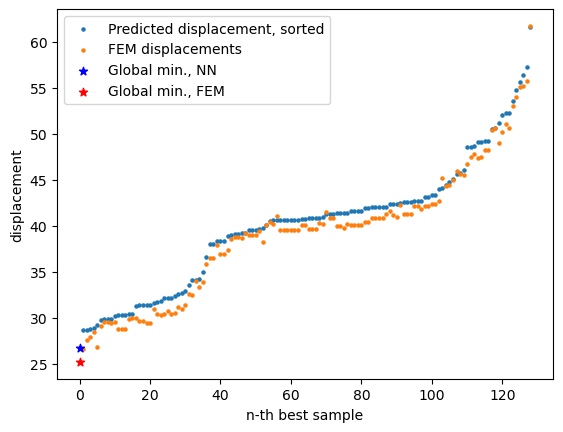

In [16]:
sorted = np.argsort(np.array(us[-1]))
plt.scatter(1+np.arange(128), us[-1][sorted], s=5)
plt.scatter(1+np.arange(128), np.array(u_real)[sorted], s=5)
plt.scatter(0, u_min, marker='*', c='b')
plt.scatter(0, u_min_FEA, marker='*', c='r')
plt.legend(['Predicted displacement, sorted', 'FEM displacements', 'Global min., NN', 'Global min., FEM'])
plt.xlabel('n-th best sample')
plt.ylabel('displacement')